In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [55]:
!pip install brian2
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [56]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [57]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

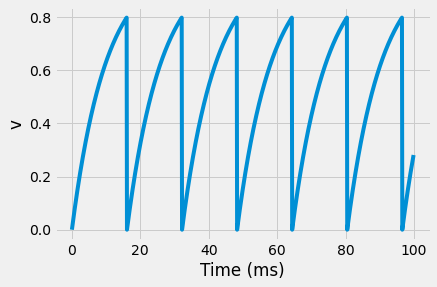

In [58]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

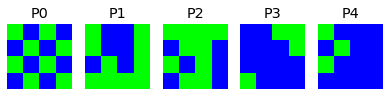

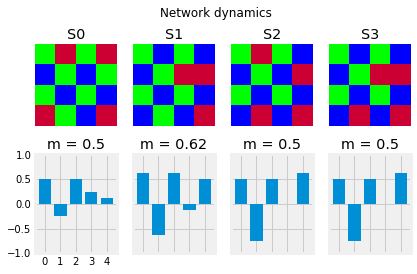

In [59]:
%matplotlib inline
!pip install neurodynex3
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

In [60]:
'''
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")
'''

'\nplist = get_patterns(4,5)\n#plot_tools.plot_pattern_list(plist)\n\ncue = deepcopy(plist)\n\nS = perturb_pattern(cue[0],3)\nwghts = calculate_weights(plist, pattern_size)\n\nstate_list =[S]\n#state_list.append(S)\n#print(state_list)\n#plot_tools.plot_pattern(S)\nfor i in range(3):\n    state_list.append(network_evolution(S,wghts))\n#    state_list.append(S)\n\nplot_tools.plot_pattern_list(plist)\n#print(state_list[0])\nplot_tools.plot_pattern(state_list[0])\nplot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")\n'

# Assignment 1

## Question 1
Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

In [61]:
#get_patterns-> generates random patterns with equal probability of both colours
def get_patterns(size, no_of_patterns):
    plist = []
    for i in range(no_of_patterns):
        pattern = np.zeros((size,size))
        for j in range(size):
            for k in range(size):
                pattern[j][k] = np.random.choice([-1,1],p=[0.5,0.5])
        plist.append(pattern)
    return plist

In [62]:
#perturb_pattern-> generates a noisy cue from given pattern 
def perturb_pattern(pattern, no_of_flips):
    pattern_size = np.size(pattern[0])
    S = pattern
    i = np.random.choice(pattern_size**2,no_of_flips,replace=False) #i = random index
    for j in range(no_of_flips): #flips no_of_flips values
        S[i[j]//pattern_size][i[j]%pattern_size] = -S[i[j]//pattern_size][i[j]%pattern_size]  
    return S

In [63]:
#calculate_weights-> gives weights 
def calculate_weights(plist, pattern_size):
    wghts = np.zeros((pattern_size**2,pattern_size**2))
    for i in range(len(plist)):
        for j in range(pattern_size**2):
            for k in range(pattern_size**2):
                wghts[j][k] += plist[i][j//pattern_size][j%pattern_size]*plist[i][k//pattern_size][k%pattern_size]                
    return wghts/pattern_size**2

In [64]:
#network_evolution-> updates the state_list using given weights
def network_evolution(S, wghts):
    S_new = deepcopy(S)
    pattern_size = len(S[0])
    for i in range(pattern_size**2):
        temp = 0 
        for j in range(pattern_size**2):
            temp += wghts[i][j]*S[j//pattern_size][j%pattern_size]
        S_new[i//pattern_size][i%pattern_size] = np.sign(temp)
    return S_new

In [65]:
#computing_overlap-> gives overlap between two patterns (code taken from the neurodynex documentation)
def compute_overlap(pattern1, pattern2):
    shape1 = pattern1.shape
    if shape1 != pattern2.shape:
        raise ValueError("patterns are not of equal shape")
    dot_prod = np.dot(pattern1.flatten(), pattern2.flatten())
    return float(dot_prod)/(np.prod(shape1))

In [66]:
#one_run-> runs the network once, 
#returns value of overlap between the cue and the original pattern, plist and state_list
def one_run(pattern_size, no_of_patterns, no_of_flips, no_of_iters):
    plist = get_patterns(pattern_size,no_of_patterns)
    cue = deepcopy(plist)
    S = perturb_pattern(cue[0],no_of_flips)
    wghts = calculate_weights(plist, pattern_size)
    state_list =[]
    state_list.append(S)

    for i in range(no_of_iters):
        state_list.append(network_evolution(S,wghts))
        S = state_list[-1]
      
    return compute_overlap(S, plist[0]) , plist, state_list


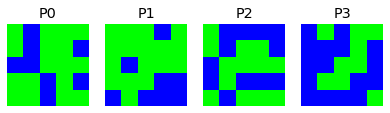

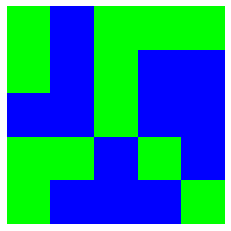

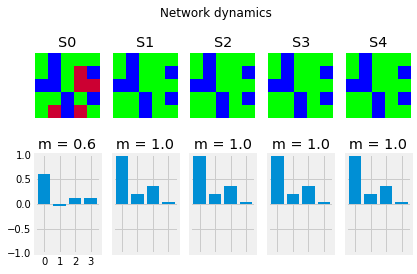

In [67]:
#plotting
overlap, plist, state_list = one_run(5,4,5,4)
plot_tools.plot_pattern_list(plist)
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")


## Question 2
Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 

(a) the informativeness of the cue

(b) the number of other patterns stored in the network

(c) the size of the network


In [68]:
#run_multiple-> runs the network for different parameters
def multiple_run(pattern_size, no_of_patterns, max_flips, no_of_runs):
    mlist = []
    no_of_iters = 5
    for flips in range(1,max_flips+1):
        avg_acc = 0
        for j in range(no_of_runs):
            avg_acc += one_run(pattern_size, no_of_patterns, flips, no_of_iters)[0] #gives average of accuracy over no_of_runs runs
        avg_acc = avg_acc/no_of_runs
        mlist.append(avg_acc)
        if (flips%10==0):
            print('#pattern: '+str(no_of_patterns)+', #flips:'+str(flips)+', accuracy: ',str(avg_acc))
    return mlist

In [69]:
#plot_acc_vs_flips -> plots accuracy against the number of perturbs
def plot_acc_vs_flips(pattern_size, max_flips, no_of_runs):    
    labels = []
    acc_list = []
    for no_of_patterns in range(5, 30, 5):
        acc = multiple_run(pattern_size, no_of_patterns, max_flips, no_of_runs)
        acc_list.append(acc)
        plt.plot(acc,linewidth=0.8)
        labels.append(str(no_of_patterns)+' patterns')
    plt.legend(labels, loc='upper right')
    plt.xlabel('Number of perturbs')
    plt.ylabel('Accuracy')
    return acc_list
  

#pattern: 5, #flips:10, accuracy:  1.0
#pattern: 5, #flips:20, accuracy:  1.0
#pattern: 5, #flips:30, accuracy:  1.0
#pattern: 5, #flips:40, accuracy:  0.496
#pattern: 5, #flips:50, accuracy:  -0.144
#pattern: 5, #flips:60, accuracy:  -0.624
#pattern: 5, #flips:70, accuracy:  -1.0
#pattern: 5, #flips:80, accuracy:  -1.0
#pattern: 5, #flips:90, accuracy:  -1.0
#pattern: 5, #flips:100, accuracy:  -1.0
#pattern: 10, #flips:10, accuracy:  1.0
#pattern: 10, #flips:20, accuracy:  1.0
#pattern: 10, #flips:30, accuracy:  0.9879999999999999
#pattern: 10, #flips:40, accuracy:  0.512
#pattern: 10, #flips:50, accuracy:  -0.024
#pattern: 10, #flips:60, accuracy:  -0.42800000000000005
#pattern: 10, #flips:70, accuracy:  -0.976
#pattern: 10, #flips:80, accuracy:  -0.9359999999999999
#pattern: 10, #flips:90, accuracy:  -0.992
#pattern: 10, #flips:100, accuracy:  -1.0
#pattern: 15, #flips:10, accuracy:  0.968
#pattern: 15, #flips:20, accuracy:  0.9879999999999999
#pattern: 15, #flips:30, accuracy:  0.9

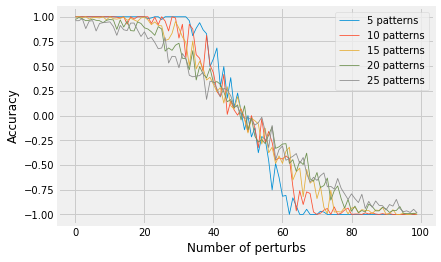

In [70]:
acc_list = plot_acc_vs_flips(10, 100, 5)

In [73]:
def run_multiple_2(pattern_size, no_of_patterns, no_of_flips, no_of_runs):
    no_of_iters = 5
    avg_acc = 0
    for j in range(no_of_runs): #averaging accuracy over the given number of runs
        avg_acc += one_run(pattern_size, no_of_patterns, no_of_flips, no_of_iters) 
    avg_acc = avg_acc/no_of_runs
    print(str(pattern_size)+':'+str(avg_acc))
    return avg_acc

def plot_acc_vs_size(max_size, no_of_patterns, percent_flips, no_of_runs):
  acc = []
  for pattern_size in range(5,max_size+1):
    no_of_flips = (int)(percent_flips*pattern_size*pattern_size)
    acc.append(run_multiple_2(pattern_size, no_of_patterns, no_of_flips, no_of_runs))
  
  return acc
acc = plot_acc_vs_size(50,5,0.45,5)

### 2(a)
**Observation 1**: Increase in number of flips leads to decrease in accuracy (for constant number of patterns stored in memory)

Explanation: Increase in number of flips => cue is more different from the original pattern => accuracy is bound to decrease

**Observation 2**: When number of flips is nearly the number of neurons in the pattern, accuracy dips to -1.

Explanation: 100% flipping essentially means giving a cue which is complement of the original pattern. Hence, -1 accuracy is understandable. 

### 2(b)

**Observation 1:** Model diverges for smaller flip values as the number of patterns in memory increase.

Explanation: Higher number of patterns confuse the model, as the perturbed cue would find similarity with annother pattern.

**Observation 2:** As number of patterns increase, drop in accuracy becomes more gradual. That is, when the number of patterns are less, the drop in accuracy is sharper.

Explanation: I am not very sure about this. But seems like for a smaller number of patterns in the network, the model is either very confident about the cue-pattern match or very confident that the cue does not match the pattern.

## 2(c)

**Observation** : As size of network increases, accuracy increases. 

## Question 3
Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

In [74]:
#loads MNIST dataset
from tensorflow import keras
from tensorflow.keras import layers
(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

In [75]:
#preprocessing MNIST dataset
# Taken from https://fsix.github.io/mnist/Deskewing.html

from PIL import Image

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)

    return interpolation.affine_transform(image,affine,offset=offset)

def crop_image_only_outside(img,tol=0): #tol refers to tolerance
    imageBox = Image.fromarray(img).getbbox()
    cropped = Image.fromarray(img).crop(imageBox)
    return cropped

def mnist_data_preprocessing(j, pattern_size=14,threshold=40):
    image=X_train[j]
    image=deskew(X_train[j])
    image= crop_image_only_outside(image)
    pat_max=np.array( image).shape
    im1=np.array(image)
    if(pattern_size==28):
      im = (np.array(Image.fromarray(im1).resize(size=(pat_max[0], pat_max[0]))))      
    else:  
      im = (np.array(Image.fromarray(im1).resize(size=(pattern_size, pattern_size))))
    im=(im>threshold)*1  
    im[im==0]=-1  
    return im

In [76]:
#get_patterns_MNIST_trainset-> get MNIST patterns for training set
def get_patterns_MNIST_trainset(pattern_size=14, pattern_per_digit=1, threshold=90):
  pattern_list=[]
  n_patterns=10
  for i in range(10):
        indices = np.nonzero(y_train == i)[0][:pattern_per_digit]

        for j in indices:
            
            im = mnist_data_preprocessing(j, pattern_size, threshold)             
            pattern_list.append(im)
    
  pattern_list = random.sample(pattern_list, len(pattern_list)) 
  plot_tools.plot_pattern_list(plist)
  return pattern_list

plist = get_patterns_MNIST_trainset(pattern_size=10,pattern_per_digit=2)

AttributeError: ignored

In [77]:
#get_patterns_MNIST_testset -> returns test set, containing testsize number of items
def get_patterns_MNIST_testset(pattern_size=14, testsize=1000, testThreshold=98):
  xtest= []
  ytest= []
  
  for i in range(testsize):
    xtest.append(mnist_data_preprocessing_test(i, pattern_size,testThreshold))
  ytest=y_test[:testsize]

  return xtest,ytest

In [78]:
#get_patterns_MNIST->returns plist and test dataset
def get_patterns_MNIST(pattern_size=14,n_patterns=2, testsize=1000, memThreshold=40, testThreshold=38):
  
  plist=get_patterns_MNIST_trainset(pattern_size,n_patterns, memThreshold)
  xtest,ytest=get_patterns_MNIST_testset(pattern_size, testsize, testThreshold)
  return plist,xtest,ytest 

## Question 4
Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

**Demerits**: We do not make use of the entire training set, and as a result, the efficiency of our model depends on the random images we choose. As digits belonging to the same class can be very different from each other, this might lead to poor results.

**Merit:** An apparent merit of the Hopfield network is that it does not need to be trained, the weights are calculated only once and as a result, the model is much faster than a classical/deep supervised learning models.

## Acknowledgements 


1.   https://fsix.github.io/mnist/Deskewing.html
2.   https://neuronaldynamics-exercises.readthedocs.io/en/latest/
3. Discussed code and ideas with Urbi and Aayush

